In [1]:
%matplotlib inline
import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sn
import numpy as np
import importlib.util
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use("ggplot")

In [2]:
# Import CL functions
spec = importlib.util.spec_from_file_location(
    "critical_loads", "/home/jovyan/projects/critical_loads_2/notebooks/critical_loads.py"
)
cl = importlib.util.module_from_spec(spec)
spec.loader.exec_module(cl)

In [ ]:
# Connect to Nivabase
eng = nivapy.da.connect()

# Compare 1995 and 2019 survey results

This notebook generates a one-page summary plot for each parameter in the 1000 Lake survey.

## 1. Stations

Read stations and assign to regions.

In [ ]:
# Get stations
stn_df = nivapy.da.select_resa_project_stations([4530], eng)

# Assign acid region IDs
shp_path = r"../data/norway_regions.shp"
reg_gdf = gpd.read_file(shp_path)
stn_df = nivapy.spatial.identify_point_in_polygon(stn_df, reg_gdf, poly_col="name")

print(len(stn_df), "stations in project.")

stn_df.head()

## 2. Get parameters measured in 2019

In [ ]:
# Time period of interest
st_dt = "2019-08-01"
end_dt = "2019-12-31"

par_df = nivapy.da.select_resa_station_parameters(
    stn_df["station_id"].unique(), st_dt, end_dt, eng
)

par_df.head()

## 3. Get water chemistry

In [ ]:
# Data from 1995
wc_95, dups_95 = nivapy.da.select_resa_water_chemistry(
    stn_df["station_id"].unique(),
    par_df,
    "1995-08-01",
    "1995-12-31",
    eng,
    drop_dups=True,
)

# Data from 2019
wc_19, dups_19 = nivapy.da.select_resa_water_chemistry(
    stn_df["station_id"].unique(), par_df, st_dt, end_dt, eng, drop_dups=True
)

# Get the "1000 Lakes" samples
# Only surface samples
wc_95 = wc_95.query("(depth1 == 0) and (depth2 == 0)")
wc_19 = wc_19.query("(depth1 == 0) and (depth2 == 0)")
del wc_95["depth1"], wc_95["depth2"], wc_19["depth1"], wc_19["depth2"]

# F is only measured for 1000 Lakes
wc_95.dropna(subset=["F_µg/l"], inplace=True)
wc_19.dropna(subset=["F_µg/l"], inplace=True)

assert len(wc_19) == 1001

# Remove Åsmundvatnet as sample contaminated with sea water
wc_19 = wc_19.query("station_code != '1630-1-19'")

# Calculate averages for stations with multiple samples
idx_cols = ["station_id", "station_code", "station_name"]
wc_95 = wc_95.groupby(idx_cols).mean().reset_index()
wc_19 = wc_19.groupby(idx_cols).mean().reset_index()

print(len(wc_95), "samples in 1995.")
print(len(wc_19), "samples in 2019.")

## 4. Calculate derived parameters

### 4.1. LAL

In [ ]:
# Calculate LAL
wc_95["LAL_µg/l"] = wc_95["Al/R_µg/l"] - wc_95["Al/Il_µg/l"]
wc_19["LAL_µg/l"] = wc_19["Al/R_µg/l"] - wc_19["Al/Il_µg/l"]

### 4.2. ALK-E

See e-mail from Øyvind G received 12.06.2020 at 16:33 for the equation:

$$ALKE = (ALK * 1000 - 31.6) + 0.646(ALK * 1000 - 31.6)^{0.5}$$

In [ ]:
# Calculate ALKE
wc_95["ALKE_µeq/l"] = (wc_95["ALK_mmol/l"] * 1000 - 31.6) + 0.646 * (
    (wc_95["ALK_mmol/l"] * 1000 - 31.6) ** 0.5
)
wc_95["ALKE_µeq/l"].fillna(0, inplace=True)

wc_19["ALKE_µeq/l"] = (wc_19["ALK_mmol/l"] * 1000 - 31.6) + 0.646 * (
    (wc_19["ALK_mmol/l"] * 1000 - 31.6) ** 0.5
)
wc_19["ALKE_µeq/l"].fillna(0, inplace=True)

### 4.3. ANC

In [ ]:
def calculate_anc(df):
    """ Calculate ANC based on data in RESA.
    
            ANC = (ECa+EMg+EK+ENa+ENH4) - (ECl+ESO4+ENO3)
            
    Args:
        df: Dataframe. As returned by nivapy.da.select_resa_water_chemistry()
        
    Returns:
        The dataframe is returned with a new column, 'ANC_µeq/l', added.
    """
    # Tabulate chemical properties
    chem_dict = {
        "molar_mass": [96.06, 35.45, 40.08, 24.31, 14.01, 39.10, 22.99, 14.01],
        "valency": [2, 1, 2, 2, 1, 1, 1, 1],
        "resa2_ref_ratio": [0.103, 1.0, 0.037, 0.196, "N/A", 0.018, 0.859, "N/A"],
    }

    chem_df = pd.DataFrame(
        chem_dict,
        index=[
            "SO4_mg/l",
            "Cl_mg/l",
            "Ca_mg/l",
            "Mg_mg/l",
            "NO3-N_µg/l N",
            "K_mg/l",
            "Na_mg/l",
            "NH4-N_µg/l N",
        ],
    )
    chem_df = chem_df[["molar_mass", "valency", "resa2_ref_ratio"]]

    # Convert to microequivalents
    for par in [
        "SO4_mg/l",
        "Cl_mg/l",
        "Ca_mg/l",
        "Mg_mg/l",
        "NO3-N_µg/l N",
        "K_mg/l",
        "Na_mg/l",
        "NH4-N_µg/l N",
    ]:
        val = chem_df.loc[par, "valency"]
        mm = chem_df.loc[par, "molar_mass"]

        if par == "NO3-N_µg/l N":
            df["ENO3_µeq/l"] = df[par] * val / mm
        elif par == "NH4-N_µg/l N":
            df["ENH4_µeq/l"] = df[par] * val / mm
        else:
            name = par.split("_")[0]
            df[f"E{name}_µeq/l"] = df[par] * val * 1000.0 / mm

    #    # Apply sea-salt correction
    #    for par in ['ESO4_µeq/l', 'EMg_µeq/l', 'ECa_µeq/l']:#, 'ENa_µeq/l', 'EK_µeq/l']:
    #        ref = chem_df.loc[par.split('_')[0][1:]+'_mg/l', 'resa2_ref_ratio']
    #        df[par] = df[par] - (ref*df['ECl_µeq/l'])

    # Calculate ANC = (ECa+EMg+EK+ENa+ENH4) - (ECl+ESO4+ENO3)
    df["ANC_µeq/l"] = (
        df["ECa_µeq/l"]
        + df["EMg_µeq/l"]
        + df["EK_µeq/l"]
        + df["ENa_µeq/l"]
        + df["ENH4_µeq/l"]
    ) - (df["ECl_µeq/l"] + df["ESO4_µeq/l"] + df["ENO3_µeq/l"])

    # Remove intermediates
    df.drop(
        [
            "ESO4_µeq/l",
            "ECl_µeq/l",
            "EMg_µeq/l",
            "ECa_µeq/l",
            "ENO3_µeq/l",
            "EK_µeq/l",
            "ENa_µeq/l",
            "ENH4_µeq/l",
        ],
        axis=1,
        inplace=True,
    )

    return df

In [ ]:
# Calculate ANC
wc_95 = calculate_anc(wc_95)
wc_19 = calculate_anc(wc_19)

## 4. Plot data

In [ ]:
def plot_points(
    df,
    par,
    ax,
    lat="latitude",
    lon="longitude",
    cmap="coolwarm",
    s=10,
    title=None,
    vmin=None,
    vmax=None,
    vmax_pct=0.95,
    cbar_ticks=None,
    cbar_labels=None,
):
    """ Plot Norwegian point data on specified axis.
    """

    if vmax and vmax_pct:
        raise ValueError("Please specify 'vmax' or 'vmax_pct', not both.")

    # Plot Norway
    shp = cartopy.io.shapereader.natural_earth(
        resolution="50m", category="cultural", name="admin_0_countries"
    )
    reader = cartopy.io.shapereader.Reader(shp)
    countries = reader.records()

    # Add Norway outline
    for country in countries:
        if country.attributes["NAME"] == "Norway":
            ax.add_geometries(
                [country.geometry],
                ccrs.PlateCarree(),  # CRS of Natural Earth data
                facecolor="none",
                edgecolor="black",
                linewidth=1,
                zorder=5,
            )

    if vmax_pct:
        vmax = df[par].describe(percentiles=[0.95,]).loc["95%"]

    # Add points using linear colour ramp from 0 to vmax
    pts = ax.scatter(
        df[lon].values,
        df[lat].values,
        c=df[par].values,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=s,
        zorder=5,
        edgecolors="none",
        transform=ccrs.PlateCarree(),
    )

    # Add axis for colourbar
    cax = inset_axes(
        ax,
        width="5%",
        height="30%",
        loc="lower left",
        bbox_to_anchor=(0.8, 0.05, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0,
    )

    # Add colourbar
    cbar = fig.colorbar(pts, cax=cax, ticks=cbar_ticks)
    if cbar_labels:
        cbar.ax.set_yticklabels(cbar_labels)

    # Turn off border around subplot
    ax.outline_patch.set_edgecolor("white")

    if title:
        ax.set_title(title, fontsize=12, loc="left")

The data below is taken from Øyvind's spreadsheet (see e-mail received 15.06.2020 at 11:19.

In [ ]:
# Set scale choices for scatterplots from Øyvind's spreadsheet
# (log_xy, lod_1995, lod_2019)
axis_opt_dict = {
    "ALK": False,
    "ALKE": False,
    "Al/Il": False,
    "Al/R": False,
    "As": False,
    "Ca": False,
    "Cd": False,
    "Cl": False,
    "Co": False,
    "Cr": False,
    "Cu": False,
    "F": False,
    "Fe": False,
    "KOND": False,
    "K": False,
    "Mg": False,
    "Mn": False,
    "NH4-N": False,
    "NO3-N": False,
    "Na": False,
    "Ni": False,
    "Pb": False,
    "SO4": False,
    "SiO2": False,
    "TOC": False,
    "TOTN": False,
    "TOTP": False,
    "Zn": False,
    "pH": False,
    "LAL": False,
    "ANC": False,
}

In [ ]:
# Loop over parameters
for col in wc_19.columns:
    if col in wc_95.columns:
        if col not in idx_cols:
            par, unit = col.split("_")
            print("Processing:", par)

            # Get 2019 data
            df19 = wc_19[["station_id", col]].dropna()
            nvals = len(df19)

            # Join co-ords
            df19 = pd.merge(
                df19,
                stn_df[["station_id", "latitude", "longitude", "name"]],
                how="left",
                on="station_id",
            )

            df9519 = pd.merge(
                df19,
                wc_95[["station_id", col]],
                how="left",
                on="station_id",
                suffixes=["_19", "_95"],
            ).dropna()

            # Calc ratio 2019:1995
            df9519["ratio_2019:1995"] = df9519[col + "_19"] / df9519[col + "_95"]
            df9519["log(ratio_2019:1995)"] = np.log10(df9519["ratio_2019:1995"])

            # Melt to lon
            melt_df = df9519[["station_id", "name", col + "_95", col + "_19"]].copy()
            melt_df.columns = ["station_id", "Region", "1995", "2019"]
            melt_df = pd.melt(
                melt_df,
                id_vars=["station_id", "Region"],
                var_name="Year",
                value_name=f"{par} ({unit})",
            )

            # Define co-ord system
            crs = ccrs.AlbersEqualArea(
                central_longitude=15,
                central_latitude=65,
                false_easting=650000,
                false_northing=800000,
                standard_parallels=(55, 75),
            )

            # Setup plot template
            fig = plt.figure(figsize=(12, 15))
            gs = fig.add_gridspec(ncols=2, nrows=5)
            ax1 = fig.add_subplot(gs[0:3, 0], projection=crs)
            ax1.set_extent([0, 1300000, 0, 1600000], crs=crs)

            ax2 = fig.add_subplot(gs[0:3, 1], projection=crs)
            ax2.set_extent([0, 1300000, 0, 1600000], crs=crs)

            #            ax3 = fig.add_subplot(gs[2, 0])
            #            ax4 = fig.add_subplot(gs[2, 1])
            ax3 = fig.add_subplot(gs[3:, :], aspect="equal")

            # Plot values in 2019
            if par == "pH":
                title = f"(a) {par} in 2019 (n = {nvals})"
            else:
                title = f"(a) {par} in 2019 ({unit}; n = {nvals})"

            plot_points(df19, par=col, ax=ax1, title=title)

            # Plot ratio of values 2019:1995
            if par == "pH":
                # Plot pH ratios directly
                plot_points(
                    df9519,
                    par="ratio_2019:1995",
                    ax=ax2,
                    # vmin=-1,
                    # vmax=1,
                    # vmax_pct=None,
                    title="(b) Value 2019 / Value 1995",
                    # cbar_ticks=[-1, -0.7, -0.3, 0, 0.3, 0.7, 1],
                    # cbar_labels=["÷10", "÷5", "÷2", "Equal", "x2", "x5", "x10"],
                )
            else:
                # Plor log ratio
                plot_points(
                    df9519,
                    par="log(ratio_2019:1995)",
                    ax=ax2,
                    vmin=-1,
                    vmax=1,
                    vmax_pct=None,
                    title="(b) log(Value 2019 / Value 1995)",
                    cbar_ticks=[-1, -0.7, -0.3, 0, 0.3, 0.7, 1],
                    cbar_labels=["÷10", "÷5", "÷2", "Equal", "x2", "x5", "x10"],
                )

            #            # Plot CDF
            #            # If IQR of data is zero (e.g. because most values are LOD), Seaborn fails to
            #            # select bandwidth for KDE. See https://github.com/mwaskom/seaborn/issues/1990
            #            # Set bandwidth for F in 1995 manually
            #            if par == "F":
            #                sn.distplot(
            #                    df9519[col + "_95"],
            #                    hist=False,
            #                    kde_kws={"cumulative": True, "bw": 0.1},
            #                    ax=ax3,
            #                    label="1995",
            #                )
            #
            #            else:
            #                sn.distplot(
            #                    df9519[col + "_95"],
            #                    hist=False,
            #                    kde_kws={"cumulative": True},
            #                    ax=ax3,
            #                    label="1995",
            #                )
            #
            #            sn.distplot(
            #                df9519[col + "_19"].values,
            #                hist=False,
            #                kde_kws={"cumulative": True},
            #                ax=ax3,
            #                label="2019",
            #            )
            #
            #            ax3.set_title(
            #                "(c) Cumulative distribution functions", fontsize=12, loc="left"
            #            )
            #            ax3.set_xlabel(f"{par} ({unit})", fontsize=10)
            #            ax3.set_ylabel("Probability", fontsize=10)

            #            # Scatter plot
            #            ax3.plot(
            #                df9519[col + "_95"],
            #                df9519[col + "_19"],
            #                c=df9519["name"],
            #                fillstyle="none",
            #                markeredgewidth=0.5,
            #            )

            # Scatter plot
            df9519.rename({"name": "Region"}, axis=1, inplace=True)
            sn.scatterplot(
                x=df9519[col + "_95"],
                y=df9519[col + "_19"],
                hue=df9519["Region"],
                ax=ax3,
            )

            ax3.plot(
                df9519[col + "_19"],
                df9519[col + "_19"],
                ls="--",
                c="0.5",
                label="1:1 line",
            )

            if log_axis_scale_dict[par]:
                ax3.set(xscale="log", yscale="log")

            ax3.legend(loc="best")
            ax3.set_title("(c) Scatter plot", fontsize=12, loc="left")
            ax3.set_xlabel(f"{par} in 1995 ({unit})", fontsize=10)
            ax3.set_ylabel(f"{par} in 2019 ({unit})", fontsize=10)

            #            # Ensure plot is square
            #            ax_min = min(ax3.get_xlim()[0], ax3.get_ylim()[0])
            #            ax_max = max(ax3.get_xlim()[1], ax3.get_ylim()[1])
            #            ax3.set_xlim((ax_min, ax_max))
            #            ax3.set_ylim((ax_min, ax_max))

            #            # Box plots
            #            box = sn.violinplot(
            #                data=melt_df, x="Region", y=f"{par} ({unit})", hue="Year", ax=ax5
            #            )
            #            box.set_xticklabels(box.get_xticklabels(), rotation=30, ha="right")
            #            ax5.set_title("(e) Violin plots", fontsize=12, loc="left")

            plt.suptitle(par, fontsize=20, y=0.9, fontweight="bold")
            plt.subplots_adjust(hspace=0)

            # Save
            png_path = f"../output/summary_plots/1000_lakes_2019_{par.replace('/', '-').lower()}.png"
            plt.savefig(png_path, dpi=200)
            plt.close()

## 5. Runoff and deposition

### 5.1. Runoff

Maps of runoff based on ERA5.

In [ ]:
# Read nc
nc_path = r"../../../era5_tmp_pptn_runoff_1979-2019_monthly.nc"
ds = xr.open_dataset(nc_path)

# 'expver' = 1 is up to end of 2019; 'expver' = 2 is for most recent data
ds = ds.sel(expver=1).drop("expver")

ds = ds.load()

ds

In [ ]:
# Convert average runoff and pptn over month in m/day to mm/month
ds["ro"] = ds["ro"] * ds["ro"].time.dt.days_in_month * 1000
ds["tp"] = ds["tp"] * ds["tp"].time.dt.days_in_month * 1000

# Convert K to C
ds["t2m"] = ds["t2m"] - 273.15


# Aggregate to annual
ro = ds["ro"].resample({"time": "A"}).sum()
tp = ds["tp"].resample({"time": "A"}).sum()
tmp = ds["t2m"].resample({"time": "A"}).mean()

# Use ro == 0 as no data mask
tmp = tmp.where(ro != 0)
tp = tp.where(ro != 0)
ro = ro.where(ro != 0)

ds2 = xr.merge([ro, tp, tmp])
ds2["time"] = ds2["time"].dt.year

ds2 = ds2.rename(
    {"ro": "Runoff (mm)", "tp": "Precipitation (mm)", "t2m": "Temperature (°C)"}
)

ds2

In [ ]:
# Define co-ord system
crs = ccrs.AlbersEqualArea(
    central_longitude=15,
    central_latitude=65,
    false_easting=650000,
    false_northing=800000,
    standard_parallels=(55, 75),
)

# Setup plot
fig = plt.figure(figsize=(12, 18))
axes = []
for i in range(6):
    ax = fig.add_subplot(3, 2, i + 1, projection=crs)
    ax.set_extent([0, 1300000, 0, 1600000], crs=crs)
    axes.append(ax)

# Plot vars
ds2["Precipitation (mm)"].sel(time=1995).plot.contourf(
    ax=axes[0], vmin=300, vmax=3500, transform=ccrs.PlateCarree()
)
ds2["Precipitation (mm)"].sel(time=2019).plot.contourf(
    ax=axes[1], vmin=300, vmax=3500, transform=ccrs.PlateCarree()
)
ds2["Temperature (°C)"].sel(time=1995).plot.contourf(
    ax=axes[2], vmax=15, transform=ccrs.PlateCarree()
)
ds2["Temperature (°C)"].sel(time=2019).plot.contourf(
    ax=axes[3], vmax=15, transform=ccrs.PlateCarree()
)
ds2["Runoff (mm)"].sel(time=1995).plot.contourf(
    ax=axes[4], vmin=0, vmax=2000, transform=ccrs.PlateCarree()
)
ds2["Runoff (mm)"].sel(time=2019).plot.contourf(
    ax=axes[5], vmin=0, vmax=2000, transform=ccrs.PlateCarree()
)

# Define Natural Earth data
# Land
land_50m = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    edgecolor="black",
    facecolor="none",
    linewidth=1,
)
# Sea
sea_50m = cfeature.NaturalEarthFeature(
    category="physical", name="ocean", scale="50m", edgecolor="none", facecolor="white",
)

# Add geo data
[ax.add_feature(sea_50m) for ax in axes]
[ax.add_feature(land_50m) for ax in axes]

axes[0].set_title("Annual precipitation in 1995")
axes[1].set_title("Annual precipitation in 2019")
axes[2].set_title("Annual temperature in 1995")
axes[3].set_title("Annual temperature in 2019")
axes[4].set_title("Annual runoff in 1995")
axes[5].set_title("Annual runoff in 2019")

png_path = r"../output/pptn_temp_runoff_1995-2019.png"
plt.savefig(png_path, dpi=200)

### 5.2. Deposition

The following code needs to be run on the JupyterHub.

In [3]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


In [4]:
# Show series already in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng)

    # Just data of interest
    ser_grid = ser_grid.query("grid == 'blr'")

    display(ser_grid)

,series_id,name,short_name,grid,description
0,1,Middel 1978-1982,7882,blr,Fordelt til BLR av NILU 2002
1,2,Middel 1992-1996,9296,blr,Fordelt til BLR av NILU 2002
2,3,Middel 1997-2001,9701,blr,Fordelt til BLR av NILU 2002
3,4,Middel 2002-2006,0206,blr,Fordelt til BLR av NILU 2008 (Wenche Aas)
24,25,Middel 2007-2011,0711,blr,Fordelt til BLR av NILU 2012 (Wenche Aas)
25,26,Middel 2012-2016,1216_old,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; old method)
26,27,Middel 2012-2016 (new),1216_blrgrid,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; new method)
28,29,Middel 1983-1987,8387,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)
29,30,Middel 1988-1992,8892,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)


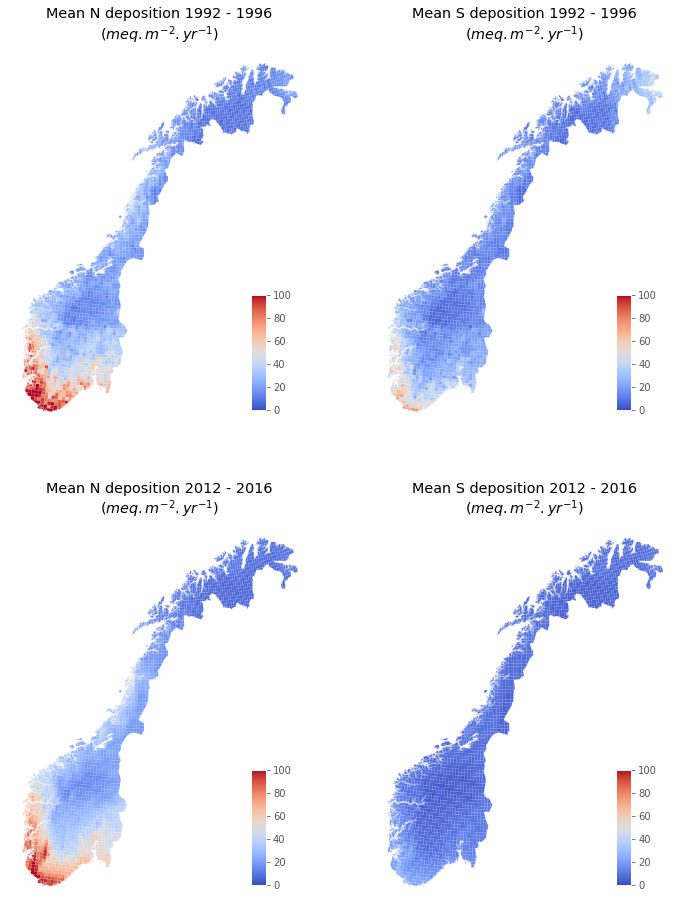

In [5]:
# Get deposition data
short_names = ["9296", "1216_old"]

title_dict = {'9296':'1992 - 1996',
              '1216_old':'2012 - 2016',
             }

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 16))

for idx, name in enumerate(short_names):
    series_id = int(ser_grid.query("short_name == @name")["series_id"].values[0])

    # Get dep data
    n_gdf = cl.extract_deposition_as_gdf(series_id, "nitrogen", eng)
    s_gdf = cl.extract_deposition_as_gdf(series_id, "sulphur", eng)   
    
    # Plot N
    cax_n = inset_axes(
        axes[idx, 0],
        width="5%",
        height="30%",
        loc="lower left",
        bbox_to_anchor=(0.8, 0.05, 1, 1),
        bbox_transform=axes[idx, 0].transAxes,
        borderpad=0,
    )
    
    n_gdf.plot(
        column="ndep_meqpm2pyr",
        cmap="coolwarm",
        edgecolor=None,
        legend=True,
        vmin=0,
        vmax=100,
        ax=axes[idx, 0],
        cax=cax_n
    )
    
    axes[idx, 0].set_title('Mean N deposition %s\n($meq.m^{-2}.yr^{-1})$' % title_dict[name])
    
    # Plot S
    cax_s = inset_axes(
        axes[idx, 1],
        width="5%",
        height="30%",
        loc="lower left",
        bbox_to_anchor=(0.8, 0.05, 1, 1),
        bbox_transform=axes[idx, 1].transAxes,
        borderpad=0,
    )
    
    s_gdf.plot(
        column="sdep_meqpm2pyr",
        cmap="coolwarm",
        edgecolor=None,
        ax=axes[idx, 1],
        legend=True,
        vmin=0,
        vmax=100,
        cax=cax_s,
    )
    
    axes[idx, 1].set_title('Mean S deposition %s\n($meq.m^{-2}.yr^{-1})$' % title_dict[name])

[ax.set_axis_off() for ax in axes.flatten()]

png_path = r'../output/n_s_deposition_1996-2016.png'
plt.savefig(png_path, dpi=200)